# 数据清洗

## sEMG 部分

### 统计 sEMG 文件

In [57]:
import os
from pathlib import Path

# Define the data directory
data_dir = Path("../data")

# Target files to search for
target_files = [
    "HorizontalTask1.lvm",
    "HorizontalTask2.lvm",
    "HorizontalTask3.lvm",
    "VerticalTask1.lvm",
    "VerticalTask2.lvm",
    "VerticalTask3.lvm"
]

# Walk through all subdirectories and find target files
results = {}
for root, dirs, files in os.walk(data_dir):
    for file in files:
        if file in target_files:
            file_path = os.path.join(root, file)
            if file not in results:
                results[file] = []
            results[file].append(file_path)

# Display results
print("=== File Search Results ===\n")
for target_file in target_files:
    if target_file in results:
        print(f"{target_file}:")
        for path in results[target_file]:
            print(f"  ✓ {path}")
    else:
        print(f"{target_file}: Not found")
    print()

# Summary
print(f"\nTotal found: {sum(len(v) for v in results.values())} files")

=== File Search Results ===

HorizontalTask1.lvm:
  ✓ ..\data\Logan_16_subjects\Data\CHEN Rongjie\3MFU\HorizontalTask1.lvm
  ✓ ..\data\Logan_16_subjects\Data\CHEN Rongjie\post\HorizontalTask1.lvm
  ✓ ..\data\Logan_16_subjects\Data\CHEN Rongjie\pre\HorizontalTask1.lvm
  ✓ ..\data\Logan_16_subjects\Data\CHEN Yulun\3MFU\HorizontalTask1.lvm
  ✓ ..\data\Logan_16_subjects\Data\CHEN Yulun\post\HorizontalTask1.lvm
  ✓ ..\data\Logan_16_subjects\Data\CHEN Yulun\pre\HorizontalTask1.lvm
  ✓ ..\data\Logan_16_subjects\Data\HUANG Weilun\3MFU\HorizontalTask1.lvm
  ✓ ..\data\Logan_16_subjects\Data\HUANG Weilun\post\HorizontalTask1.lvm
  ✓ ..\data\Logan_16_subjects\Data\HUANG Weilun\pre\HorizontalTask1.lvm
  ✓ ..\data\Logan_16_subjects\Data\LI Jiahao\3MFU\HorizontalTask1.lvm
  ✓ ..\data\Logan_16_subjects\Data\LI Jiahao\post\HorizontalTask1.lvm
  ✓ ..\data\Logan_16_subjects\Data\LI Jiahao\pre\HorizontalTask1.lvm
  ✓ ..\data\Logan_16_subjects\Data\LIANG Meiyi\3MFU\HorizontalTask1.lvm
  ✓ ..\data\Logan_16_

### 删除无关数据

In [3]:
# 仅保留各最下层（leaf）目录中的 target_files，删除其它文件
deleted = []
kept = []
print(f"Scanning {data_dir}...")
for root, dirs, files in os.walk(data_dir, topdown=False):
    root_p = Path(root)
    is_leaf = len(dirs) == 0
    for fname in files:
        p = root_p / fname
        if is_leaf and fname in target_files:
            kept.append(str(p))
            continue
        try:
            p.unlink()
            deleted.append(str(p))
        except Exception as e:
            print(f"Failed to delete {p}: {e}")
print(f"Deleted {len(deleted)} files, kept {len(kept)} files.")

Scanning ..\data...
Deleted 2186 files, kept 294 files.


### 统计保留的 sEMG 文件情况

,folder_path,file_name,count
0,Logan_16_subjects/Data/CHEN Rongjie/3MFU,HorizontalTask1.lvm,1
1,Logan_16_subjects/Data/CHEN Rongjie/3MFU,HorizontalTask2.lvm,1
2,Logan_16_subjects/Data/CHEN Rongjie/3MFU,HorizontalTask3.lvm,1
3,Logan_16_subjects/Data/CHEN Rongjie/3MFU,VerticalTask1.lvm,1
4,Logan_16_subjects/Data/CHEN Rongjie/3MFU,VerticalTask2.lvm,1
...,...,...,...
289,Logan_16_subjects/Data/ZHUO Yuanfa/pre,HorizontalTask2.lvm,1
290,Logan_16_subjects/Data/ZHUO Yuanfa/pre,HorizontalTask3.lvm,1
291,Logan_16_subjects/Data/ZHUO Yuanfa/pre,VerticalTask1.lvm,1
292,Logan_16_subjects/Data/ZHUO Yuanfa/pre,VerticalTask2.lvm,1


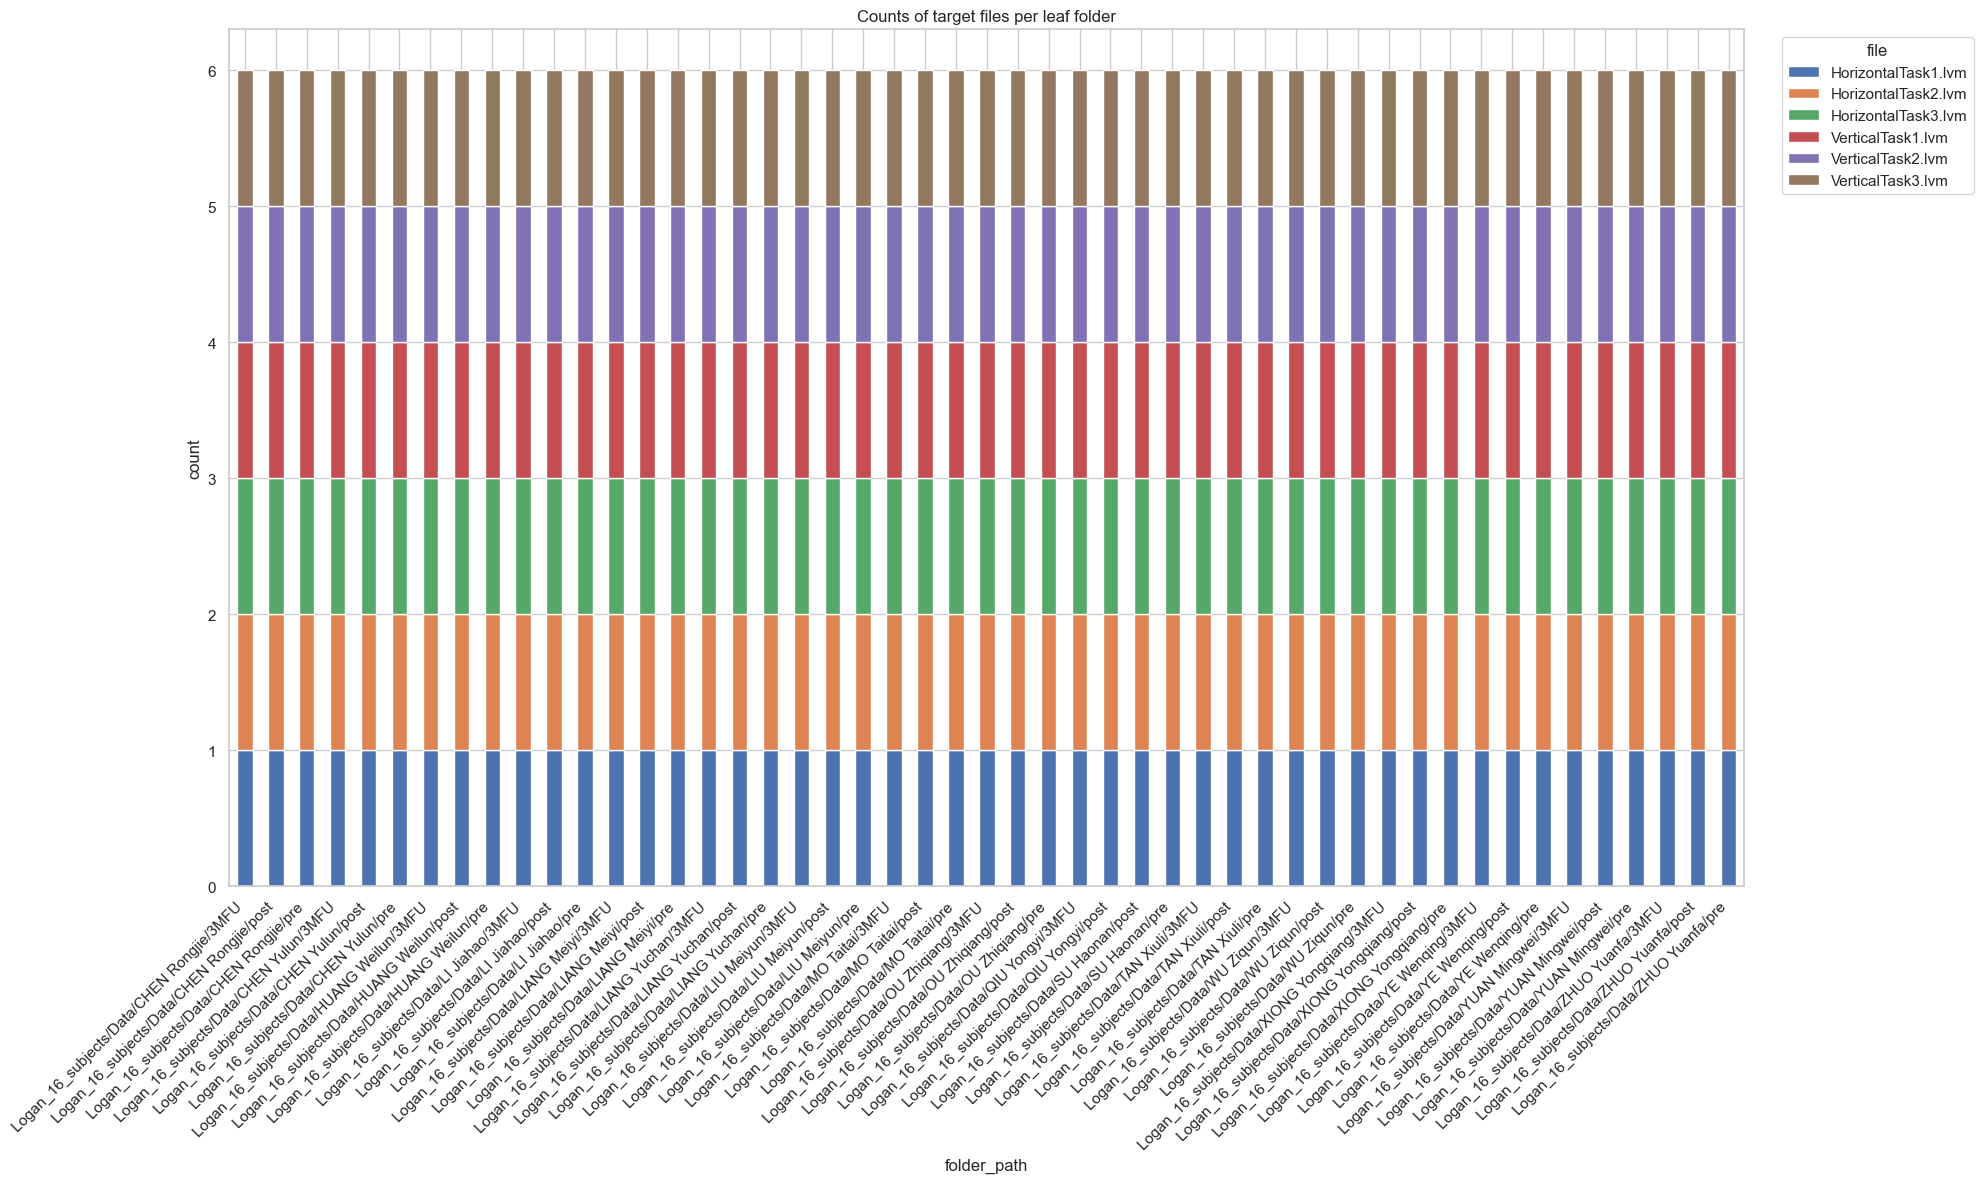

In [58]:
from pathlib import Path

import matplotlib.pyplot as plt

# use existing df, data_dir, target_files
def rel_after_data(p):
    parts = Path(p).parts
    # find "data" (case-insensitive) and take parts after it
    try:
        i = next(i for i, v in enumerate(parts) if v.lower() == "data")
        return parts[i+1:]
    except StopIteration:
        return parts

df2 = df.copy()
df2["rel_parts"] = df2["path"].apply(rel_after_data)
df2["file_name"] = df2["rel_parts"].apply(lambda x: x[-1])
# keep only the target files
df2 = df2[df2["file_name"].isin(target_files)].reset_index(drop=True)
df2["folders"] = df2["rel_parts"].apply(lambda x: x[:-1])

# normalize folder level columns
max_depth = max(len(f) for f in df2["folders"])
for i in range(max_depth):
    df2[f"level_{i+1}"] = df2["folders"].apply(lambda x: x[i] if i < len(x) else None)

group_cols = [f"level_{i+1}" for i in range(max_depth)] + ["file_name"]
counts = df2.groupby(group_cols).size().reset_index(name="count")

# structured dataframe: folder_path / file / count
counts["folder_path"] = counts[[f"level_{i+1}" for i in range(max_depth)]].fillna("").agg("/".join, axis=1).str.strip("/")
structured = counts[["folder_path", "file_name", "count"]].sort_values(["folder_path", "file_name"]).reset_index(drop=True)

display(structured)

# visualization: stacked bar per folder showing counts per file
pivot = structured.pivot(index="folder_path", columns="file_name", values="count").fillna(0)
ax = pivot.plot(kind="bar", stacked=True, figsize=(20, 12))
ax.set_ylabel("count")
ax.set_title("Counts of target files per leaf folder")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.legend(title="file", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

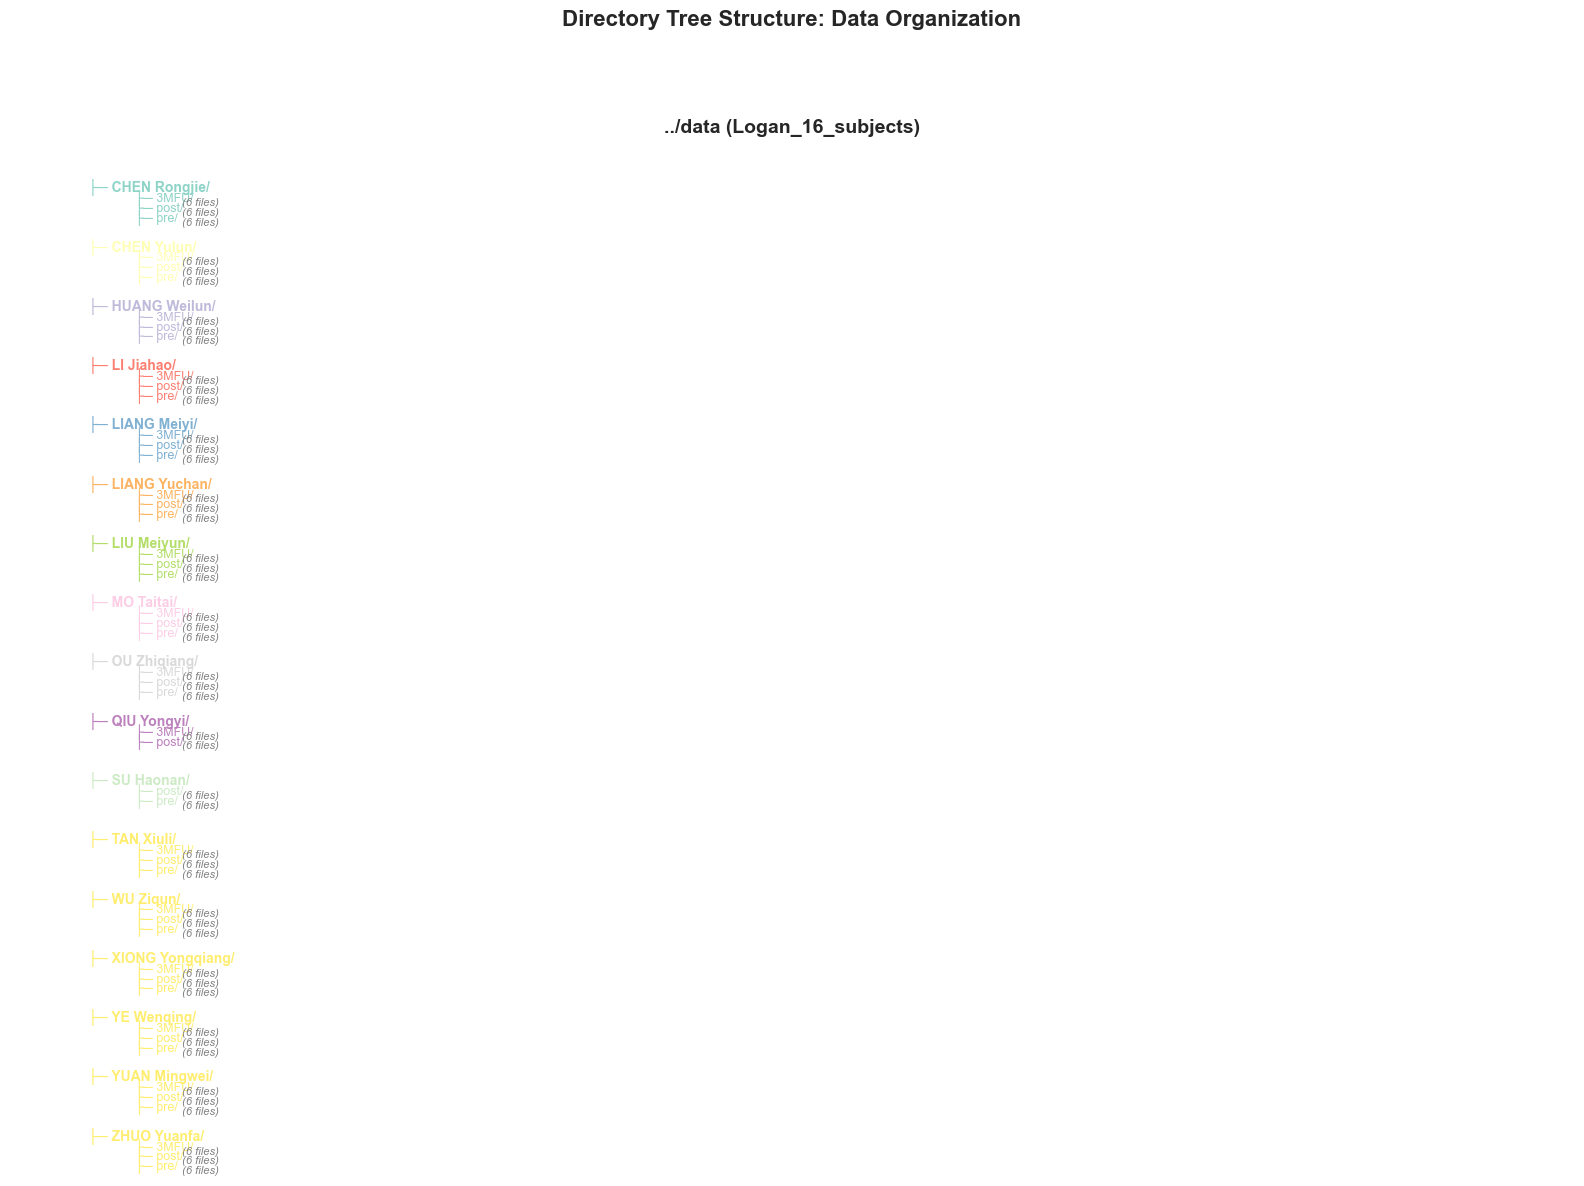


=== Summary Statistics ===

        subject phase  unique_files  total_files
   CHEN Rongjie  3MFU             6            6
   CHEN Rongjie  post             6            6
   CHEN Rongjie   pre             6            6
     CHEN Yulun  3MFU             6            6
     CHEN Yulun  post             6            6
     CHEN Yulun   pre             6            6
   HUANG Weilun  3MFU             6            6
   HUANG Weilun  post             6            6
   HUANG Weilun   pre             6            6
      LI Jiahao  3MFU             6            6
      LI Jiahao  post             6            6
      LI Jiahao   pre             6            6
    LIANG Meiyi  3MFU             6            6
    LIANG Meiyi  post             6            6
    LIANG Meiyi   pre             6            6
   LIANG Yuchan  3MFU             6            6
   LIANG Yuchan  post             6            6
   LIANG Yuchan   pre             6            6
     LIU Meiyun  3MFU             6     

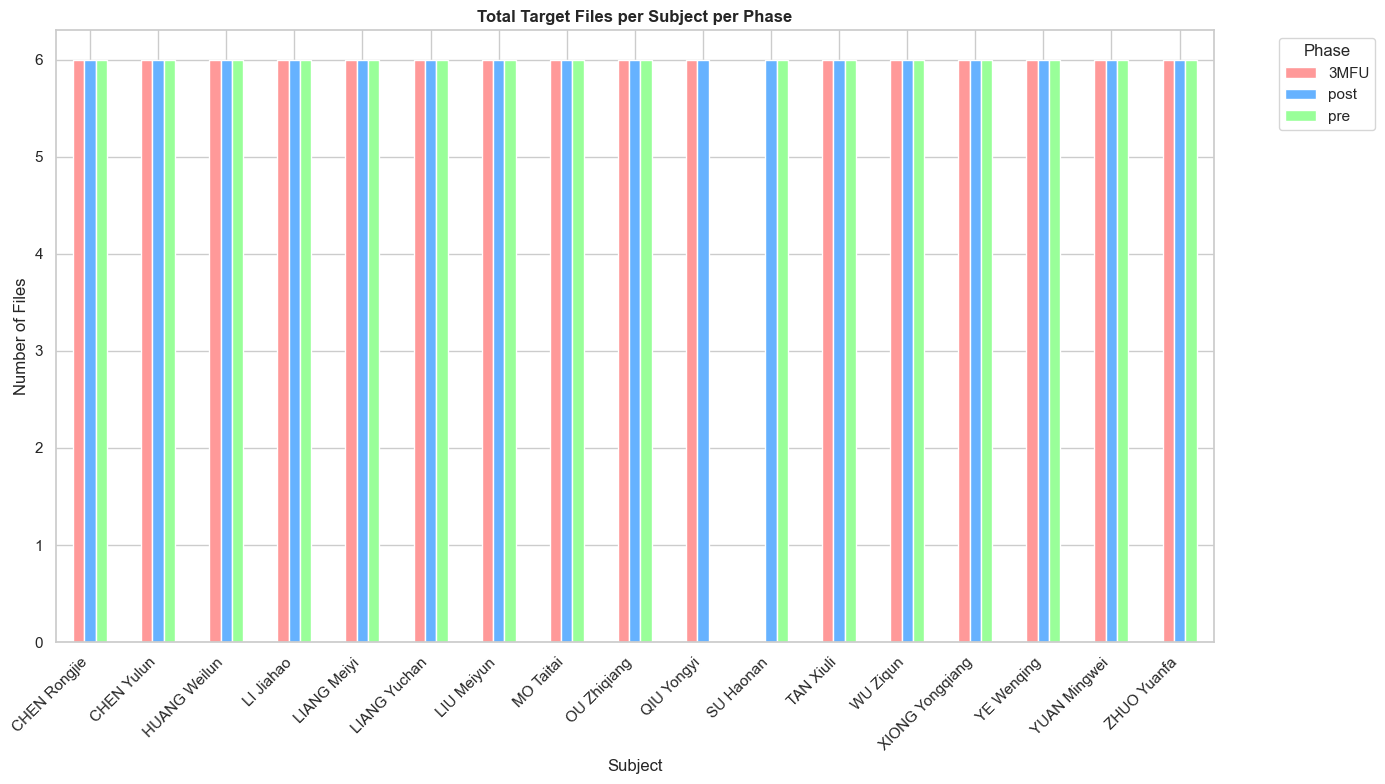

In [59]:
import pandas as pd
from matplotlib.patches import FancyBboxPatch

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Extract subject and phase info from df2
df3 = df2[['level_3', 'level_4', 'file_name']].copy()
df3.columns = ['subject', 'phase', 'file']

# Create hierarchical count: subject -> phase -> file count
hierarchy = df3.groupby(['subject', 'phase', 'file']).size().reset_index(name='count')

# Create tree structure data
subjects = hierarchy['subject'].unique()
phases_by_subject = hierarchy.groupby('subject')['phase'].unique()
files_by_subject_phase = hierarchy.groupby(['subject', 'phase'])['file'].unique()

# Draw tree visualization
fig, ax = plt.subplots(figsize=(16, 12))
ax.set_xlim(0, 100)
ax.set_ylim(0, len(subjects) * 30 + 50)
ax.axis('off')

y_pos = len(subjects) * 30
x_left = 5

# Title
ax.text(50, y_pos + 10, '../data (Logan_16_subjects)', fontsize=14, weight='bold', ha='center')

colors = plt.cm.Set3(range(len(subjects)))
file_colors = plt.cm.Pastel1(range(6))

for subj_idx, subject in enumerate(sorted(subjects)):
    y_subj = y_pos - subj_idx * 30 - 20
    
    # Subject folder
    ax.text(x_left, y_subj, f'├─ {subject}/', fontsize=10, weight='bold', color=colors[subj_idx])
    
    phases = sorted(hierarchy[hierarchy['subject'] == subject]['phase'].unique())
    
    for phase_idx, phase in enumerate(phases):
        y_phase = y_subj - (phase_idx + 1) * 5
        ax.text(x_left + 3, y_phase, f'├─ {phase}/', fontsize=9, color=colors[subj_idx])
        
        # Count files in this subject-phase combination
        files_data = hierarchy[(hierarchy['subject'] == subject) & (hierarchy['phase'] == phase)]
        total_in_phase = files_data['count'].sum()
        
        ax.text(x_left + 6, y_phase - 2, f'({total_in_phase} files)', fontsize=8, 
                style='italic', color='gray')

plt.title('Directory Tree Structure: Data Organization', fontsize=16, weight='bold', pad=20)
plt.tight_layout()
plt.show()

# Create summary statistics table
summary = hierarchy.groupby(['subject', 'phase']).agg({
    'file': 'count',
    'count': 'sum'
}).rename(columns={'file': 'unique_files', 'count': 'total_files'}).reset_index()

print("\n=== Summary Statistics ===\n")
print(summary.to_string(index=False))

# Create stacked bar chart: files per subject per phase
pivot_summary = hierarchy.groupby(['subject', 'phase']).size().reset_index(name='count')
pivot_chart = pivot_summary.pivot(index='subject', columns='phase', values='count').fillna(0)

fig, ax = plt.subplots(figsize=(14, 8))
pivot_chart.plot(kind='bar', ax=ax, color=['#FF9999', '#66B2FF', '#99FF99'])
ax.set_title('Total Target Files per Subject per Phase', fontsize=12, weight='bold')
ax.set_ylabel('Number of Files')
ax.set_xlabel('Subject')
ax.legend(title='Phase', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### 统计每个 sEMG 文件的 size (会保存统计结果于./dataExplore)

In [60]:
import pandas as pd
from pathlib import Path
from tqdm import tqdm

# 目标文件名列表
target_files = [
    "HorizontalTask1.lvm",
    "HorizontalTask2.lvm",
    "HorizontalTask3.lvm",
    "VerticalTask1.lvm",
    "VerticalTask2.lvm",
    "VerticalTask3.lvm"
]

# 遍历所有目标文件，统计shape
rows = []
# 计算总文件数用于进度条
total_files = sum(len(results.get(file_name, [])) for file_name in target_files)

with tqdm(total=total_files, desc="Processing files", unit="file") as pbar:
    for file_name in target_files:
        for file_path in results.get(file_name, []):
            p = Path(file_path)
            # SubjectName: 一级文件夹名
            subject = p.parts[-3]
            # TimeAxis: 二级文件夹名
            time_axis = p.parts[-2]
            # 读取lvm文件，假设为csv格式，跳过前N行header
            C = None
            T = None
            duration = None
            try:
                # 尝试自动检测header行数
                with open(file_path, encoding="utf-8", errors="ignore") as f:
                    lines = f.readlines()
                # 找到数据开始行
                data_start = 0
                for i, line in enumerate(lines):
                    if line.strip() and all(c.isdigit() or c in ".-,\t " for c in line.strip().replace(",", "").replace("\t", "")):
                        data_start = i
                        break
                # 读取数据
                df_tmp = pd.read_csv(file_path, sep="\t", skiprows=data_start, engine="python", header=None)
                # 去除全空行
                df_tmp = df_tmp.dropna(how="all")
                # shape: 行=采样点数, 列=通道数
                T, C = df_tmp.shape
                duration = round(T / 1200, 2)
            except Exception as e:
                C = None
                T = None
                duration = None
            rows.append({
                "SubjectName": subject,
                "TimeAxis": time_axis,
                "FileName": file_name,
                "C": C,
                "T": T,
                "DurationTime (s)": duration
            })
            pbar.update(1)

# 保存为csv
data_info = pd.DataFrame(rows)
data_info = data_info.sort_values(["SubjectName", "TimeAxis", "FileName"]).reset_index(drop=True)
data_info.to_csv("./dataExplore/dataInfo.csv", index=False)
# 同时保存为pickle，方便后续使用
data_info.to_pickle("./dataExplore/dataInfo.pkl")
print(f"\n✓ 已保存 CSV 文件: dataInfo.csv")
print(f"✓ 已保存 Pickle 文件: dataInfo.pkl")
display(data_info)

Processing files: 100%|██████████| 264/264 [00:37<00:00,  7.09file/s]


✓ 已保存 CSV 文件: dataInfo.csv
✓ 已保存 Pickle 文件: dataInfo.pkl


,SubjectName,TimeAxis,FileName,C,T,DurationTime (s)
0,CHEN Rongjie,3MFU,HorizontalTask1.lvm,7,13888,11.57
1,CHEN Rongjie,3MFU,HorizontalTask2.lvm,7,9536,7.95
2,CHEN Rongjie,3MFU,HorizontalTask3.lvm,7,16832,14.03
3,CHEN Rongjie,3MFU,VerticalTask1.lvm,7,28288,23.57
4,CHEN Rongjie,3MFU,VerticalTask2.lvm,7,16320,13.60
...,...,...,...,...,...,...
259,YUAN Mingwei,pre,HorizontalTask2.lvm,7,48768,40.64
260,YUAN Mingwei,pre,HorizontalTask3.lvm,7,25024,20.85
261,YUAN Mingwei,pre,VerticalTask1.lvm,7,30592,25.49
262,YUAN Mingwei,pre,VerticalTask2.lvm,7,28032,23.36


## Score 部分

### 清洗数据（手动清晰后的文件：clinicalScoresProcessed.xlsx）

### 标签分布

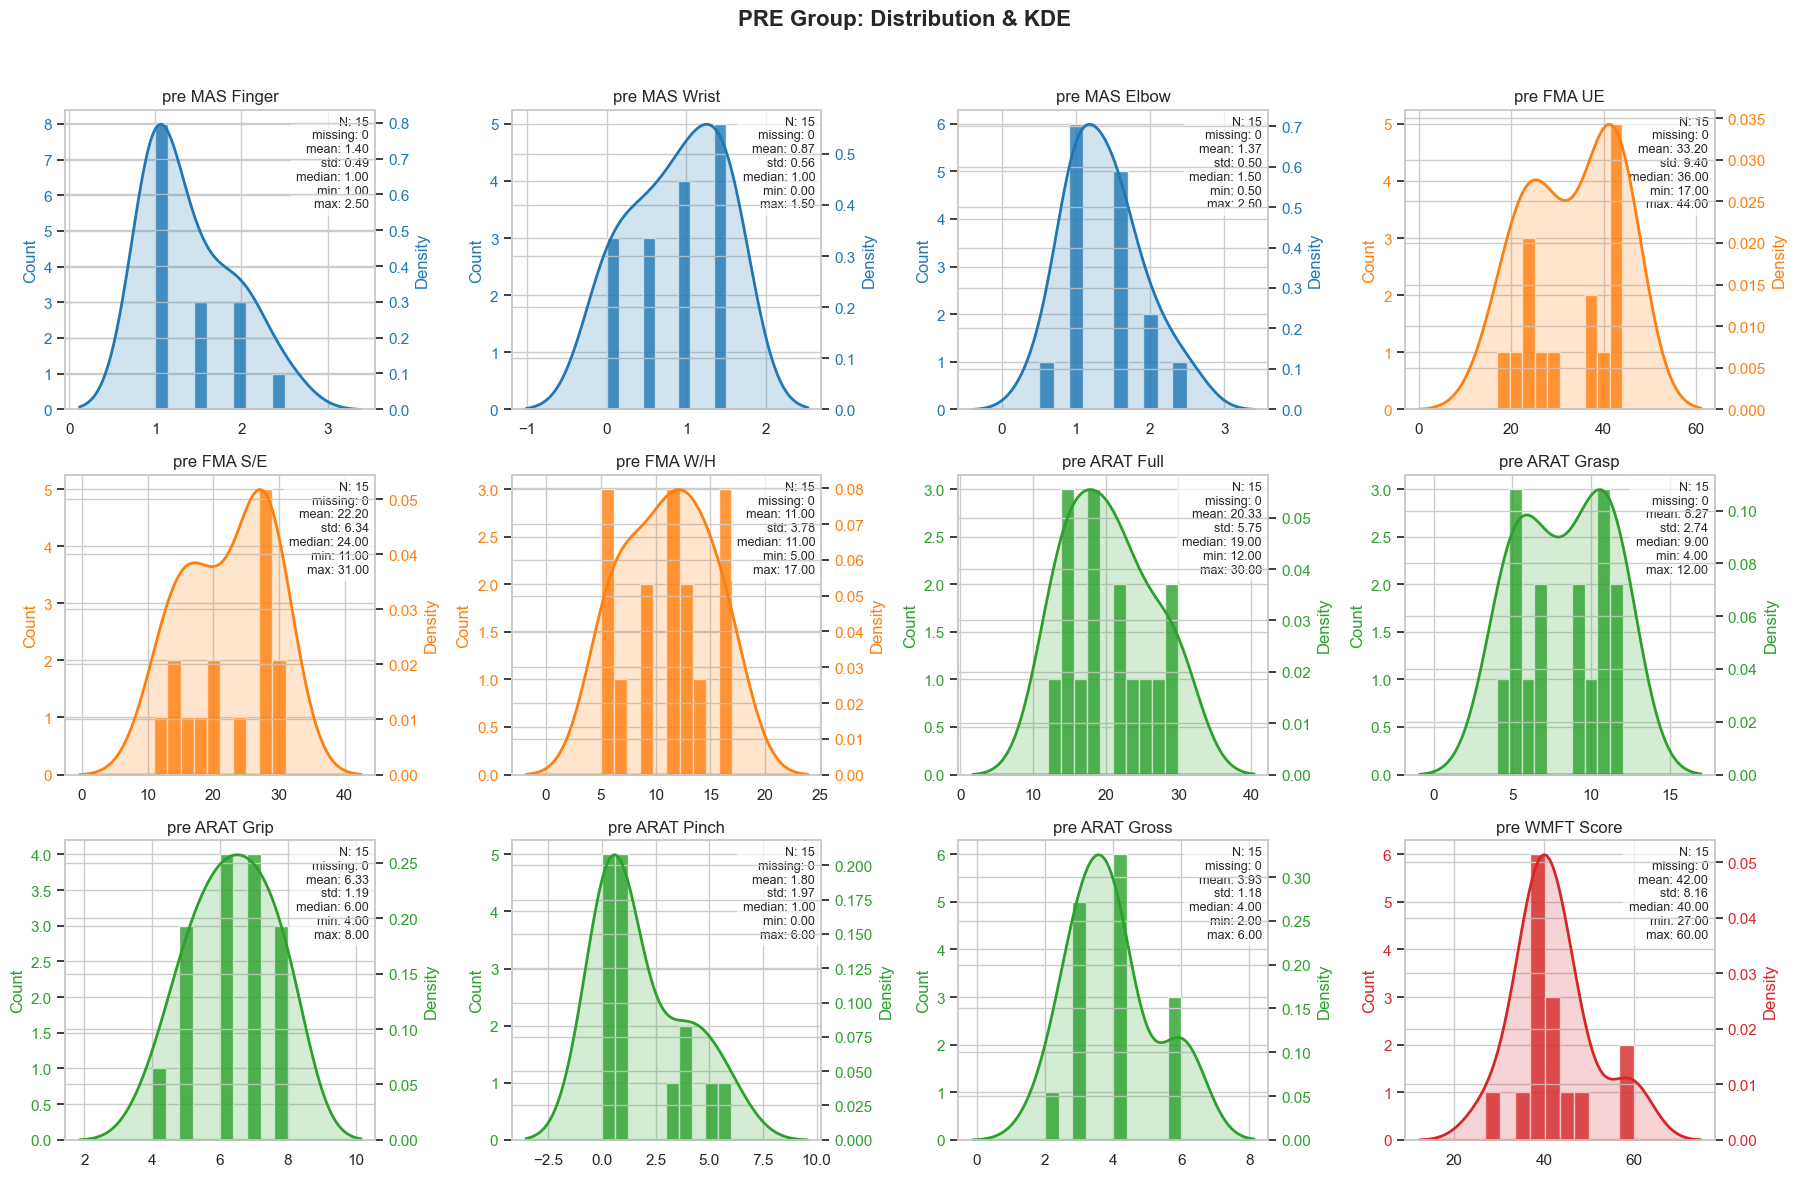

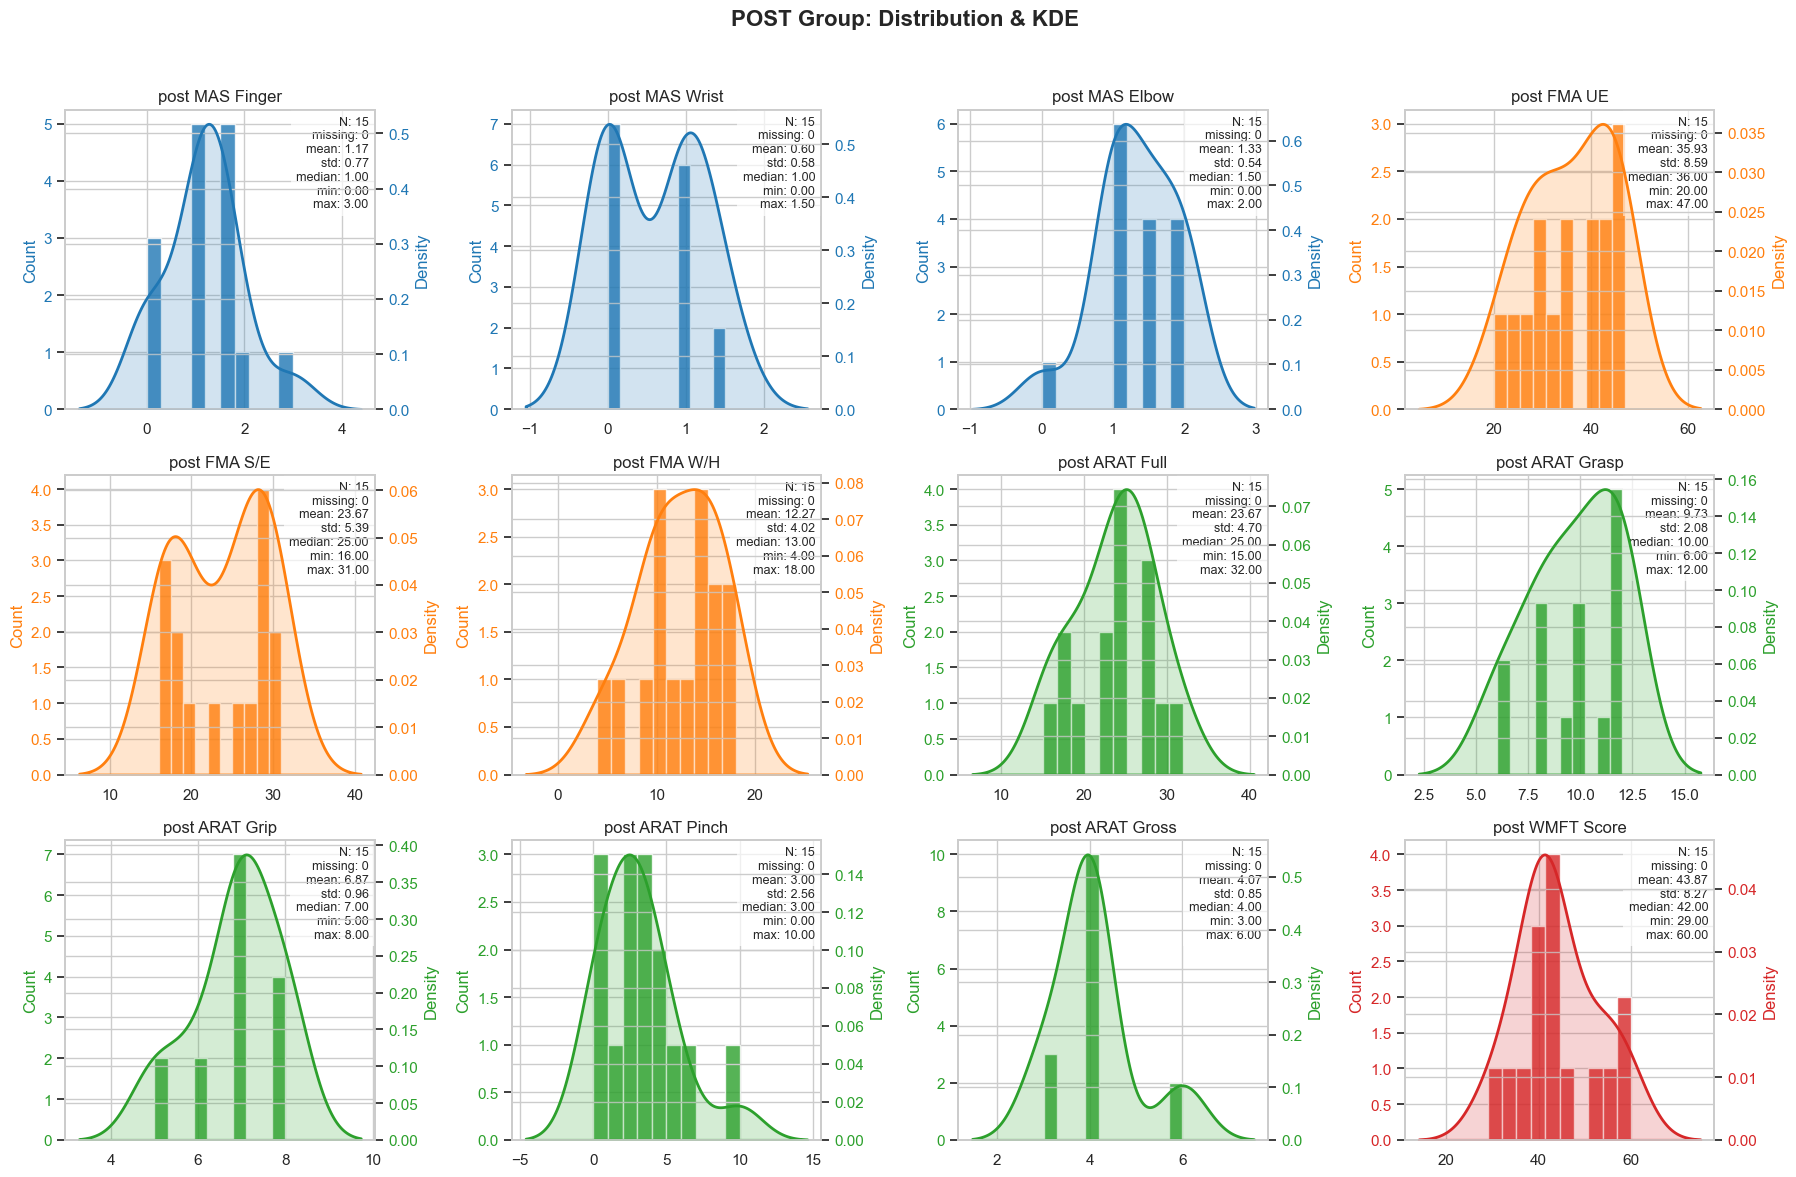

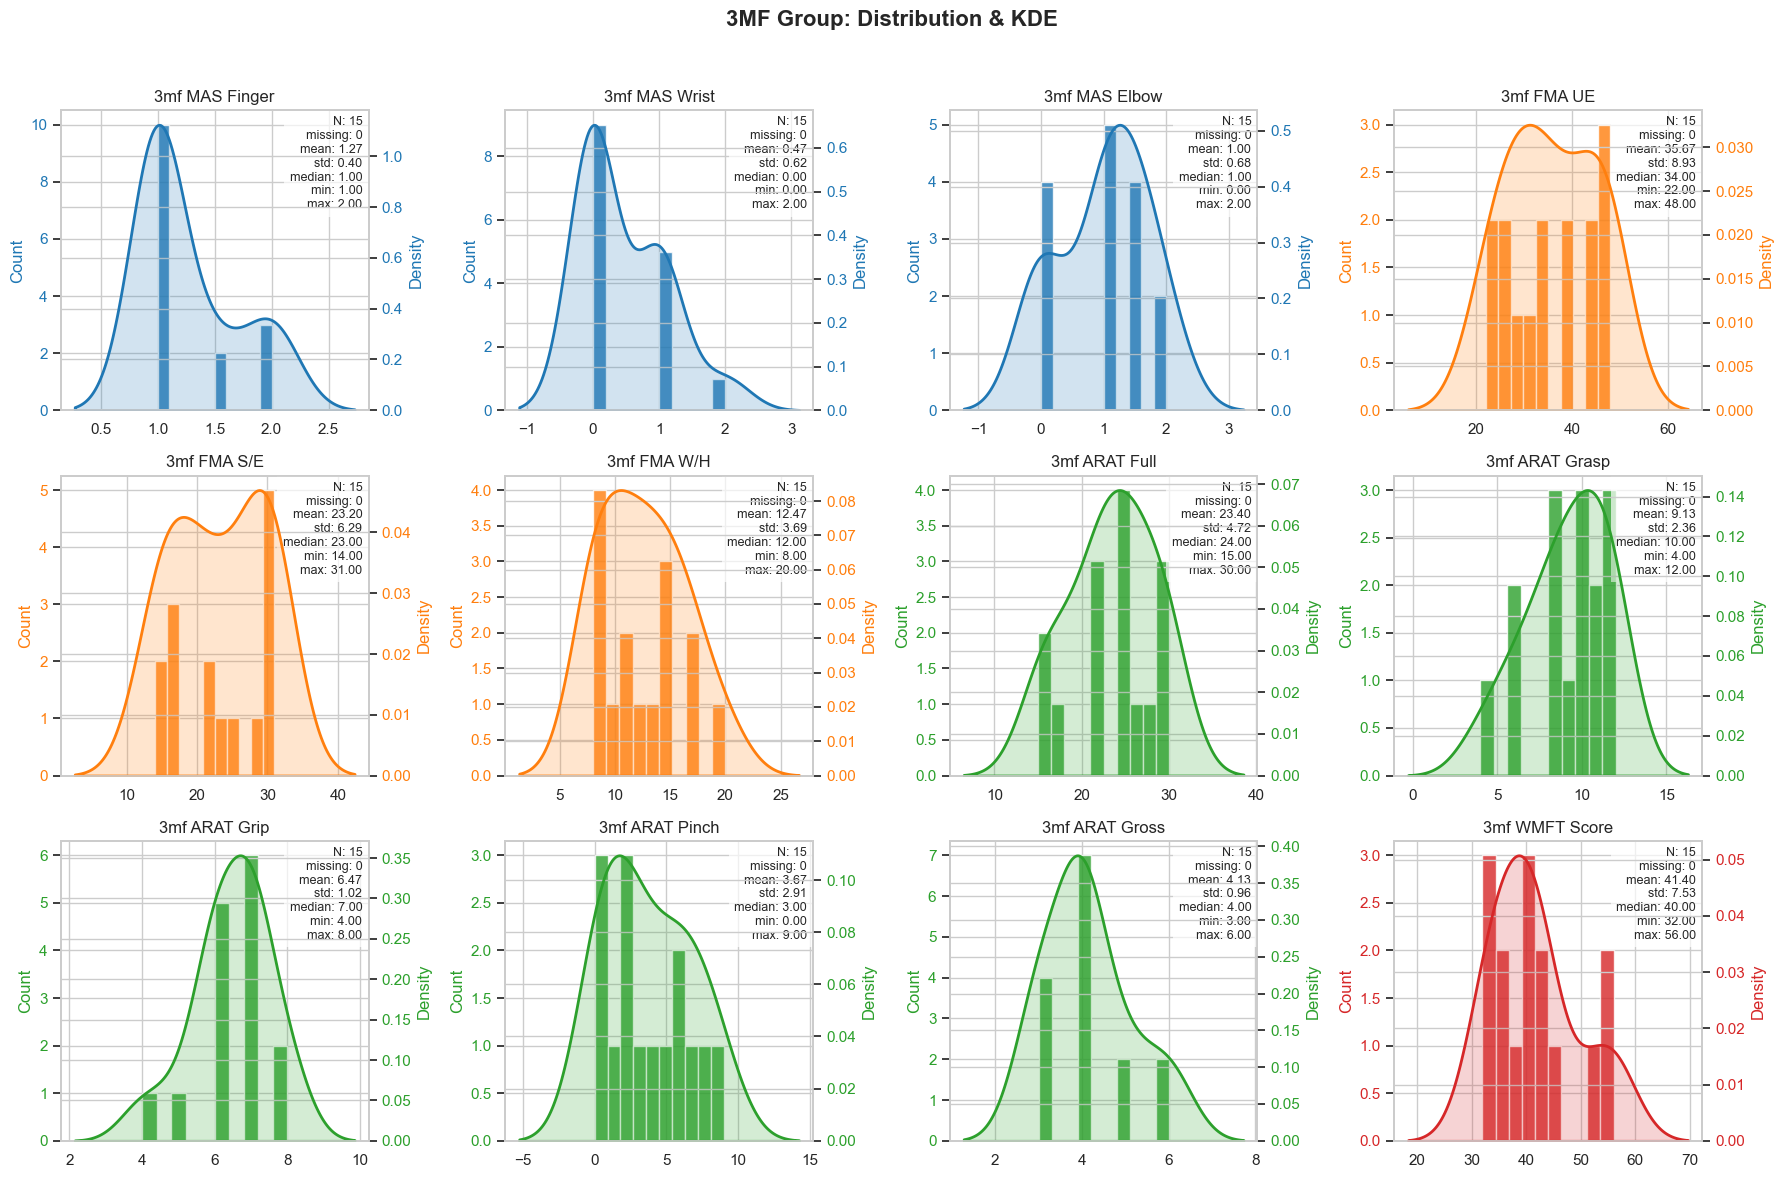

In [41]:
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt
#分别绘制 scores_df 第 7~18、22~33、37~48 列（共3组12列）的分布图（左Y轴；每一组 3*4 子图，组分别命名为pre，post，3mf））（按照第二行的名字分配色系，同名字同色系，10%透明度）；并在每个子图中绘制核密度估计分布（右Y轴）（与分布图同色系的颜色50%透明度填充，置于分布图下方。），并显示统计指标。图上的文字用英文。每个子图的命名是{组}{第二行该列的名字}{第三行该列的名字}
# 分组列索引
# 读取 Excel 文件为 DataFrame（无表头）
scores_df = pd.read_excel("../score/clinicalScoresProcessed.xlsx", header=None)
display(scores_df)
group_cols = {
    'pre': list(range(7, 19)),    # 7~18
    'post': list(range(22, 34)),  # 22~33
    '3mf': list(range(37, 49)),   # 37~48
}

# 颜色映射：根据第二行（scores_df.iloc[1]）的唯一名字分配颜色
col_names = scores_df.iloc[1]
unique_names = col_names.iloc[np.r_[group_cols['pre'], group_cols['post'], group_cols['3mf']]].unique()
palette = sns.color_palette("tab10", len(unique_names))
color_map = {name: palette[i] for i, name in enumerate(unique_names)}

for group, cols in group_cols.items():
    fig, axes = plt.subplots(3, 4, figsize=(18, 12))
    axes = axes.flatten()
    for i, col_idx in enumerate(cols):
        ax = axes[i]
        label = scores_df.iloc[1, col_idx]
        sublabel = scores_df.iloc[2, col_idx]
        color = color_map[label]
        # 数据（跳过前三行）
        data = pd.to_numeric(scores_df.iloc[3:, col_idx], errors='coerce').dropna()
        # 直方图（左Y轴）
        ax.hist(data, bins=10, color=color, alpha=0.8, label=f'Distribution: {label}', edgecolor='w')
        ax.set_ylabel('Count', color=color)
        ax.tick_params(axis='y', labelcolor=color)
        # KDE（右Y轴）
        ax2 = ax.twinx()
        if len(data) > 1:
            sns.kdeplot(data, ax=ax2, color=color, fill=True, alpha=0.2, linewidth=2, zorder=1)
        ax2.set_ylabel('Density', color=color)
        ax2.tick_params(axis='y', labelcolor=color)
        # 标题
        ax.set_title(f"{group} {label} {sublabel}", fontsize=12)
        # 统计指标
        stats = {
            'N': len(data),
            'missing': scores_df.shape[0] - 3 - len(data),
            'mean': np.nanmean(data) if len(data) else np.nan,
            'std': np.nanstd(data) if len(data) else np.nan,
            'median': np.nanmedian(data) if len(data) else np.nan,
            'min': np.nanmin(data) if len(data) else np.nan,
            'max': np.nanmax(data) if len(data) else np.nan,
        }
        stats_text = (
            f"N: {stats['N']}\n"
            f"missing: {stats['missing']}\n"
            f"mean: {stats['mean']:.2f}\n"
            f"std: {stats['std']:.2f}\n"
            f"median: {stats['median']:.2f}\n"
            f"min: {stats['min']:.2f}\n"
            f"max: {stats['max']:.2f}"
        )
        ax.text(0.98, 0.98, stats_text, transform=ax.transAxes, fontsize=9,
                verticalalignment='top', horizontalalignment='right',
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
    # 去除多余子图
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
    fig.suptitle(f"{group.upper()} Group: Distribution & KDE", fontsize=16, weight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

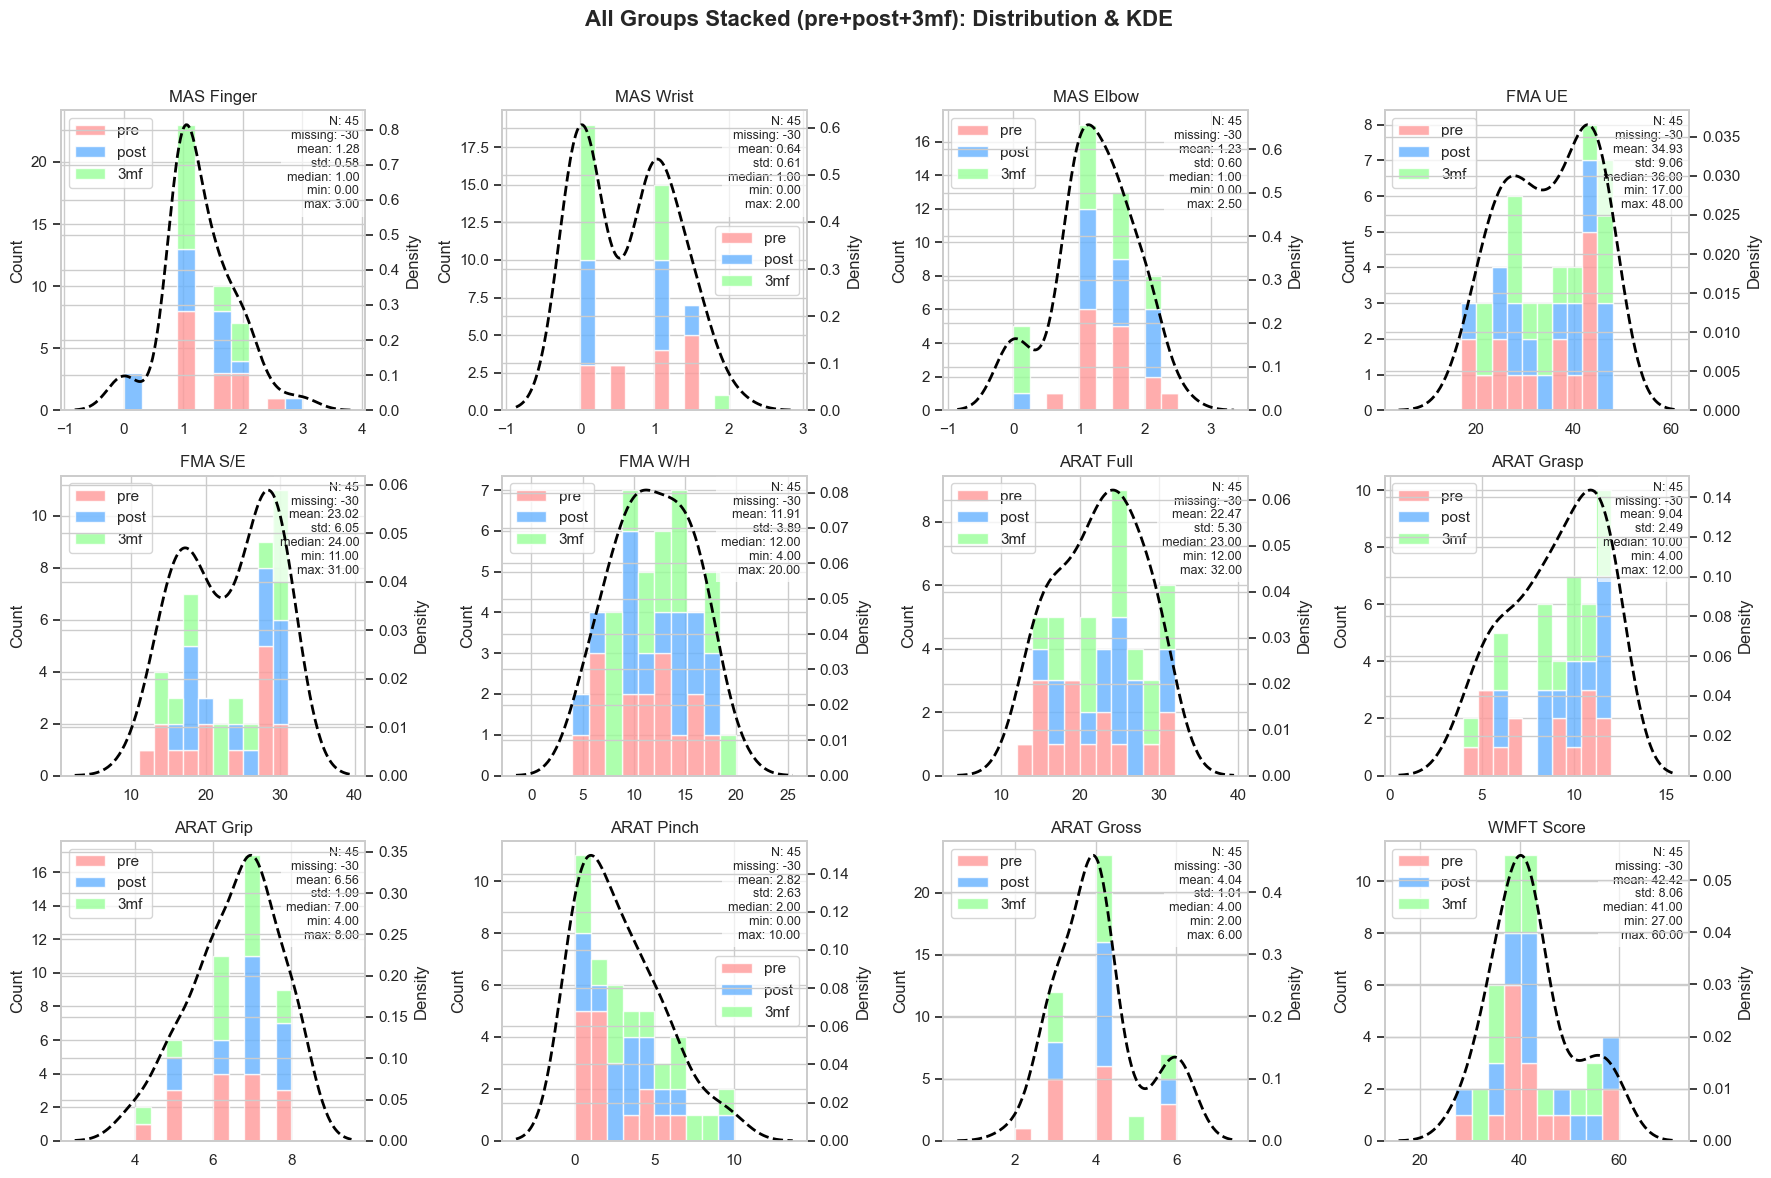

In [48]:
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt

# 分组列索引
group_cols = {
    'pre': list(range(7, 19)),    # 7~18
    'post': list(range(22, 34)),  # 22~33
    '3mf': list(range(37, 49)),   # 37~48
}

# 颜色映射：根据第二行（scores_df.iloc[1]）的唯一名字分配颜色
col_names = scores_df.iloc[1]
unique_names = col_names.iloc[np.r_[group_cols['pre'], group_cols['post'], group_cols['3mf']]].unique()
palette = sns.color_palette("tab10", len(unique_names))
color_map = {name: palette[i] for i, name in enumerate(unique_names)}

# 创建12个子图（3x4），每个子图展示三组堆叠的数据
fig, axes = plt.subplots(3, 4, figsize=(18, 12))
axes = axes.flatten()

for i in range(12):
    ax = axes[i]
    
    # 从三组中各取第 i 个指标
    col_idx_pre = group_cols['pre'][i]
    col_idx_post = group_cols['post'][i]
    col_idx_3mf = group_cols['3mf'][i]
    
    label = scores_df.iloc[1, col_idx_pre]  # 使用pre的标签
    sublabel = scores_df.iloc[2, col_idx_pre]
    
    # 获取三组数据
    data_pre = pd.to_numeric(scores_df.iloc[3:, col_idx_pre], errors='coerce').dropna()
    data_post = pd.to_numeric(scores_df.iloc[3:, col_idx_post], errors='coerce').dropna()
    data_3mf = pd.to_numeric(scores_df.iloc[3:, col_idx_3mf], errors='coerce').dropna()
    
    # 合并三组数据用于统计
    data_all = pd.concat([data_pre, data_post, data_3mf])
    
    # 绘制堆叠直方图
    ax.hist([data_pre, data_post, data_3mf], bins=10, label=['pre', 'post', '3mf'],
            color=['#FF9999', '#66B2FF', '#99FF99'], alpha=0.8, edgecolor='w', stacked=True)
    ax.set_ylabel('Count')
    ax.set_title(f"{label} {sublabel}", fontsize=12)
    ax.legend()
    
    # KDE曲线（右Y轴）
    ax2 = ax.twinx()
    if len(data_all) > 1:
        sns.kdeplot(data_all, ax=ax2, color='black', fill=False, linewidth=2, linestyle='--')
    ax2.set_ylabel('Density')
    
    # 统计指标（所有三组合并）
    stats = {
        'N': len(data_all),
        'missing': scores_df.shape[0] - 3 - len(data_all),
        'mean': np.nanmean(data_all) if len(data_all) else np.nan,
        'std': np.nanstd(data_all) if len(data_all) else np.nan,
        'median': np.nanmedian(data_all) if len(data_all) else np.nan,
        'min': np.nanmin(data_all) if len(data_all) else np.nan,
        'max': np.nanmax(data_all) if len(data_all) else np.nan,
    }
    stats_text = (
        f"N: {stats['N']}\n"
        f"missing: {stats['missing']}\n"
        f"mean: {stats['mean']:.2f}\n"
        f"std: {stats['std']:.2f}\n"
        f"median: {stats['median']:.2f}\n"
        f"min: {stats['min']:.2f}\n"
        f"max: {stats['max']:.2f}"
    )
    ax.text(0.98, 0.98, stats_text, transform=ax.transAxes, fontsize=9,
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

fig.suptitle("All Groups Stacked (pre+post+3mf): Distribution & KDE", fontsize=16, weight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

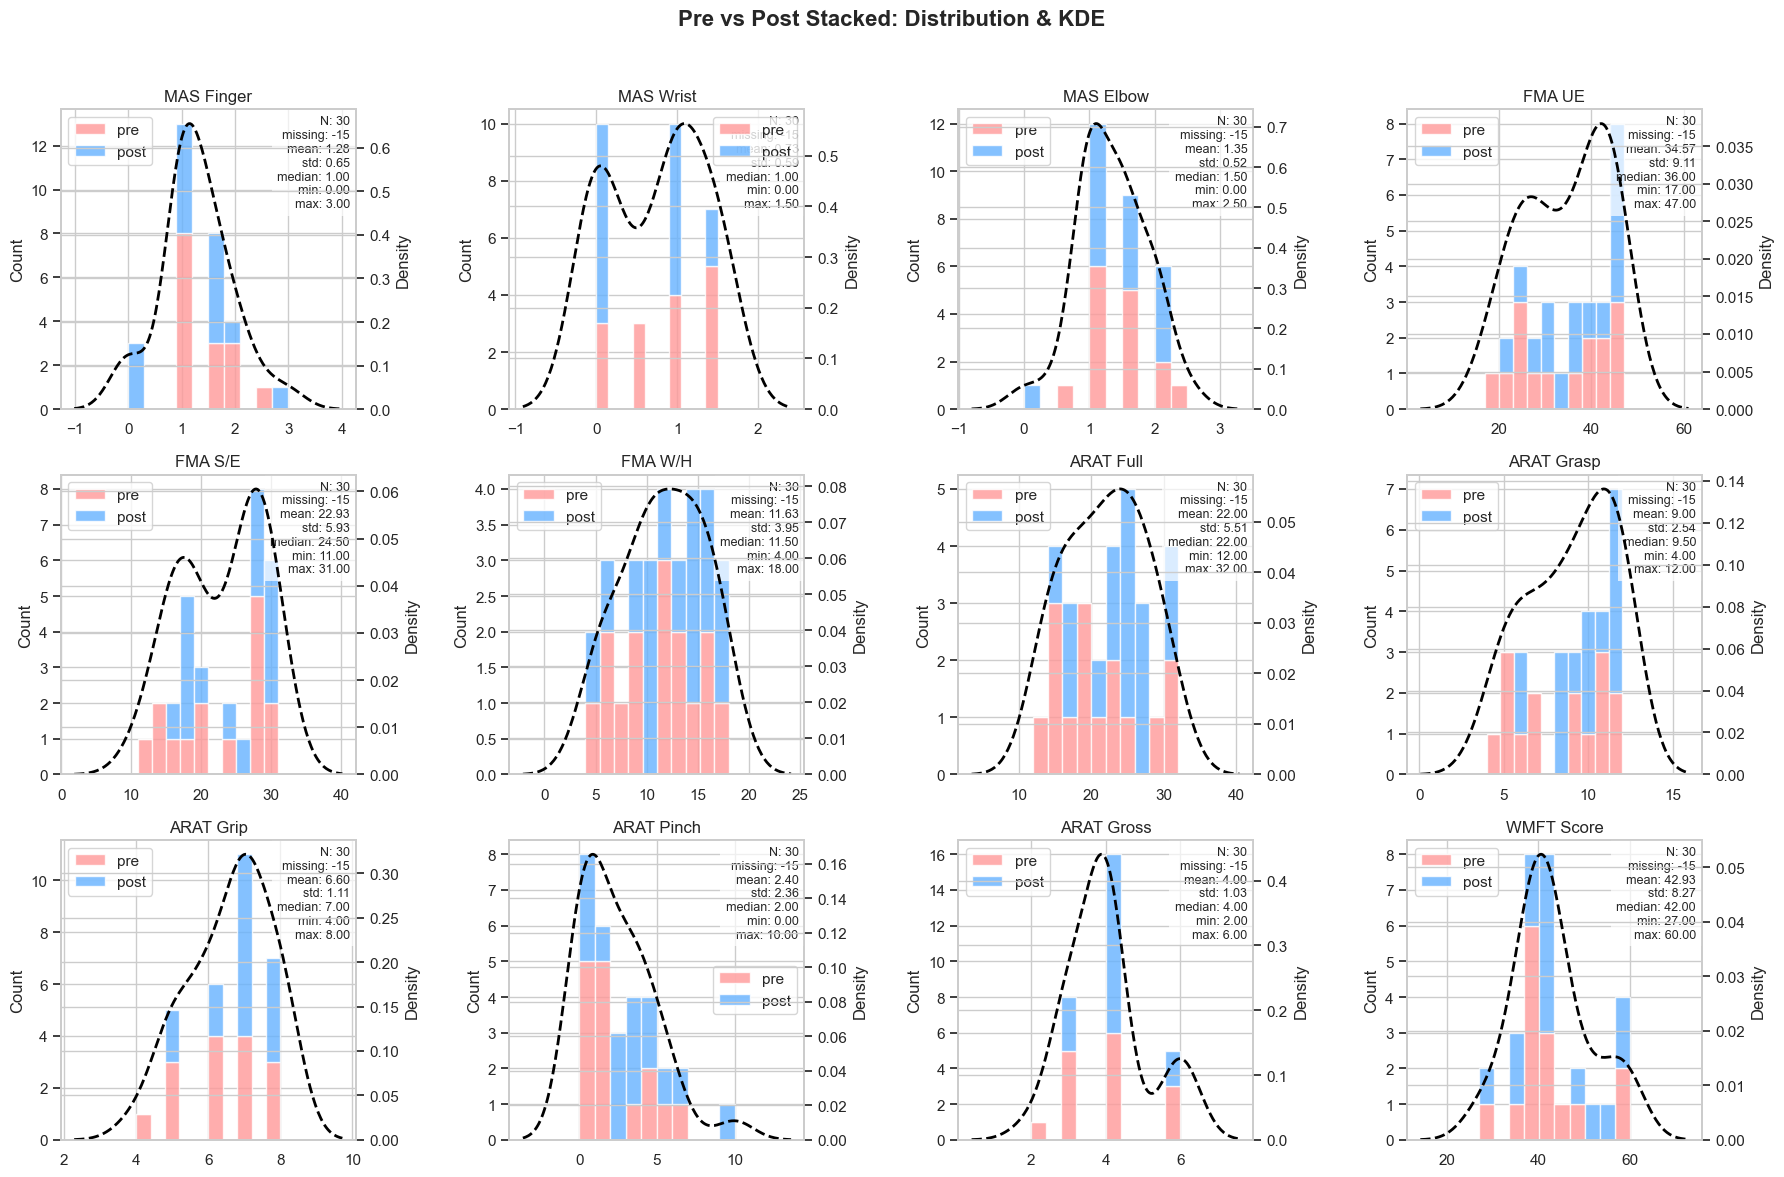

In [47]:
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt

# 分组列索引
group_cols = {
    'pre': list(range(7, 19)),    # 7~18
    'post': list(range(22, 34)),  # 22~33
}

# 颜色映射：根据第二行（scores_df.iloc[1]）的唯一名字分配颜色
col_names = scores_df.iloc[1]
unique_names = col_names.iloc[np.r_[group_cols['pre'], group_cols['post']]].unique()
palette = sns.color_palette("tab10", len(unique_names))
color_map = {name: palette[i] for i, name in enumerate(unique_names)}

# 创建12个子图（3x4），每个子图展示pre和post堆叠的数据
fig, axes = plt.subplots(3, 4, figsize=(18, 12))
axes = axes.flatten()

for i in range(12):
    ax = axes[i]
    
    # 从两组中各取第 i 个指标
    col_idx_pre = group_cols['pre'][i]
    col_idx_post = group_cols['post'][i]
    
    label = scores_df.iloc[1, col_idx_pre]  # 使用pre的标签
    sublabel = scores_df.iloc[2, col_idx_pre]
    
    # 获取两组数据
    data_pre = pd.to_numeric(scores_df.iloc[3:, col_idx_pre], errors='coerce').dropna()
    data_post = pd.to_numeric(scores_df.iloc[3:, col_idx_post], errors='coerce').dropna()
    
    # 合并两组数据用于统计
    data_all = pd.concat([data_pre, data_post])
    
    # 绘制堆叠直方图
    ax.hist([data_pre, data_post], bins=10, label=['pre', 'post'],
            color=['#FF9999', '#66B2FF'], alpha=0.8, edgecolor='w', stacked=True)
    ax.set_ylabel('Count')
    ax.set_title(f"{label} {sublabel}", fontsize=12)
    ax.legend()
    
    # KDE曲线（右Y轴）
    ax2 = ax.twinx()
    if len(data_all) > 1:
        sns.kdeplot(data_all, ax=ax2, color='black', fill=False, linewidth=2, linestyle='--')
    ax2.set_ylabel('Density')
    
    # 统计指标（两组合并）
    stats = {
        'N': len(data_all),
        'missing': scores_df.shape[0] - 3 - len(data_all),
        'mean': np.nanmean(data_all) if len(data_all) else np.nan,
        'std': np.nanstd(data_all) if len(data_all) else np.nan,
        'median': np.nanmedian(data_all) if len(data_all) else np.nan,
        'min': np.nanmin(data_all) if len(data_all) else np.nan,
        'max': np.nanmax(data_all) if len(data_all) else np.nan,
    }
    stats_text = (
        f"N: {stats['N']}\n"
        f"missing: {stats['missing']}\n"
        f"mean: {stats['mean']:.2f}\n"
        f"std: {stats['std']:.2f}\n"
        f"median: {stats['median']:.2f}\n"
        f"min: {stats['min']:.2f}\n"
        f"max: {stats['max']:.2f}"
    )
    ax.text(0.98, 0.98, stats_text, transform=ax.transAxes, fontsize=9,
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

fig.suptitle("Pre vs Post Stacked: Distribution & KDE", fontsize=16, weight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### 数据聚合（Score-dataPath）

In [51]:
from pathlib import Path

# 在 scores_df 中新增/填充 'matched_data_paths' 列：
# 对 index >= 3 的行，查找 ../data 下与第1列（列索引0）同名的文件夹，保存相对于 data_dir 的路径列表


# 确保 data_dir 已定义（来自之前的单元）
# data_dir = Path("../data")

# 读取 Excel 文件为 DataFrame（无表头）
scores_df = pd.read_excel("../score/clinicalScoresProcessed.xlsx", header=None)
display(scores_df)

def find_matches_under_data(name):
    if not isinstance(name, str) or not name.strip():
        return []
    name = name.strip()
    matches = []
    for p in data_dir.rglob('*'):
        if p.is_dir() and p.name == name:
            try:
                matches.append(str(p.relative_to(data_dir)))
            except Exception:
                matches.append(str(p))
    return matches

# 初始化列（若已存在则覆盖）
scores_df['matched_data_paths'] = [[] for _ in range(len(scores_df))]

# 从第4行（index >= 3）开始查找并赋值
for idx in scores_df.index:
    if idx >= 3:
        subj_name = scores_df.at[idx, 0]
        scores_df.at[idx, 'matched_data_paths'] = find_matches_under_data(subj_name)

# 显示结果示例
display()
scores_df.to_csv("./dataExplore/ensembledInfo.csv", index=False)

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,50,51
0,Info,Info,Info,Info,Info,Info,Info,pre,pre,pre,...,3mf,3mf,3mf,3mf,3mf,3mf,3mf,3mf,3mf,3mf
1,basicInfo,basicInfo,basicInfo,basicInfo,basicInfo,strokeInfo,strokeInfo,MAS,MAS,MAS,...,FMA,ARAT,ARAT,ARAT,ARAT,ARAT,WMFT,WMFT,WMFT,FIM
2,Suject name,Suject code,Age,Gender,Handedness,Affected side,Stroke type,Finger,Wrist,Elbow,...,W/H,Full,Grasp,Grip,Pinch,Gross,Score,Strength,Time,Full
3,QIU Yongyi,S0,52,F,R,L,Hemorrhagic,1,0.5,1.5,...,20,24,12,6,2,4,56,6.3,18.934,121
4,LI Jiahao,S1,40,M,R,R,Hemorrhagic,1.5,1.5,2.5,...,15,24,11,7,0,6,42,10.5,17.764667,124
5,LIU Meiyun,S2,42,F,R,R,Hemorrhagic,2,1.5,2,...,11,21,9,7,2,3,40,3.9,33.9,117
6,WU Ziqun,S3,59,F,R,R,Hemorrhagic,2,1.5,1,...,17,26,8,7,6,5,56,3.2,17.358667,123
7,SUN Jingqin,S4,67,F,R,L,Ischemic,1,1,1.5,...,8,15,6,6,0,3,34,3.2,52.468667,114
8,YE Wenqing,S5,61,M,R,R,Hemorrhagic,2.5,1.5,1,...,8,17,8,6,0,3,33,3.5,51.216,120
9,YUAN Mingwei,S6,60,F,R,L,Hemorrhagic,1,0,1,...,11,24,6,7,7,4,40,7.8,29.14,123
